TSORMPATZOGLOU IOANNIS

NTUA, HEP

PyHEADTAIL Simulation Framework

# MULTI-BUNCH TRACKING WITH SHM AND GAUSSIAN BEAM-BEAM KICK

In this notebook/script, we extend the previous single-bunch simulation, where we only had a Simple Harmonic Motion (SHM) restoring 
force acting on the bunch. In that earlier case, the transverse motion of the particles was governed exclusively by a linear restoring 
force of the type:

F=−k⋅x

which corresponds to an idealized quadrupole focusing system.

Here, however, we want to bring the setup closer to real collider physics, where a bunch of charged particles does not only experience 
focusing fields, but also beam-beam interactions. These arise because each bunch generates electromagnetic fields that act back on the 
other bunch. In the simplest model, the fields of the opposing bunch can be approximated by a Gaussian charge distribution, leading to 
a nonlinear beam-beam force. To model this effect, we use the Bassetti-Erskine formula, which expresses the complex electric field of 
a 2D Gaussian distribution in terms of the Faddeeva function w(z). The beam-beam kick is then applied as an additional momentum update 
on top of the SHM kick.

Key idea: We keep the same restoring constant k as before (so the linear focusing strength is unchanged) and then compare the centroid and phase-space motion with and without the beam-beam kick. This allows us to isolate and study the effect of beam-beam interactions on the dynamics.

### Summary of the approach:

->Previous version: pure SHM (linear focusing).

->Current version: SHM + nonlinear beam-beam force from Gaussian bunch.

->Goal: compare dynamics and visualize how the extra interaction modifies centroid oscillations and phase-space distribution.

### THEORY OF THE FUNCTIONS USED

apply_kick_SHM(x, xp, k):
Implements the linear restoring force kick. For a particle displaced by x, the momentum conjugate xp receives a kick Δxp = -k·x. This is the discrete update equivalent of dx'/dz = -k·x.

update_position(x, xp, dz=1):
Free drift step. The transverse coordinate evolves according to dx/dz = x'. Discretizing gives x_new = x_old + xp·dz.

bassetti_erskine(x, y, sigma_x, sigma_y):
Computes the transverse electromagnetic field of a 2D Gaussian charge distribution.

For σx = σy (circular bunch), this simplifies to z = (x + i y) / (√2 σ), and the field involves the Faddeeva function w(z) = exp(-z²)·erfc(-iz).

For σx ≠ σy (elliptical bunch), a more general expression is used.

apply_beambeam_kick_BE(coords, N, sigma_x, sigma_y, gamma, r0):
Applies the beam-beam force computed via Bassetti-Erskine to each macroparticle. The kicks are proportional to the number of particles N, the classical particle radius r0, and inversely to the relativistic γ factor. The resulting Δxp, Δyp represent the effect of the opposing bunch’s electromagnetic field.

By running the tracking loop with both SHM and beam-beam forces, we can study how the centroid motion deviates from a pure sinusoid, and how the phase-space distribution develops distortions characteristic of nonlinear forces.

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PyHEADTAIL
import matplotlib.animation as animation


# PyHEADTAIL particle class
from PyHEADTAIL.particles import Particles


# Special functions (Faddeeva)
from scipy.special import wofz

PyHEADTAIL v1.16.5


# Physics functions

In [2]:
def apply_kick_SHM(x, xp, k):
    """
    Apply Simple Harmonic Motion (SHM) restoring force kick.
    Equivalent to a thin-lens quadrupole with focusing strength k.
    Updates momentum conjugate xp as: xp_new = xp_old - k * x.
    """
    xp -= k * x
    return xp

In [3]:
def update_position(x, xp, dz=1):
    """
    Update transverse position with drift step dz.
    Implements x_new = x_old + xp * dz, i.e. free propagation.
    """
    x += xp * dz
    return x

In [4]:
def bassetti_erskine(x, y, sigma_x, sigma_y):
    """
    Compute Bassetti-Erskine complex field for Gaussian beam.
    Returns (Ex, Ey) components encoded via Re[w(z)], Im[w(z)].
    - If sigma_x = sigma_y: circular Gaussian bunch.
    - Else: elliptical Gaussian bunch.
    """
    if sigma_x == sigma_y:
       z = (x + 1j * y) / (np.sqrt(2) * sigma_x)
       w = wofz(z)
       return np.real(w), np.imag(w)
    else:
       z = (x + 1j * y) / (np.sqrt(2 * (sigma_x**2 - sigma_y**2)))
       w = wofz(z)
       return np.real(w), np.imag(w)

In [5]:
def apply_beambeam_kick_BE(coords, N, A, sigma_x, sigma_y, gamma, r0):
    """
    Apply Gaussian beam-beam kick using Bassetti-Erskine field.
    Each particle at (x,y) receives a momentum kick Δxp, Δyp proportional to:
    (2 N r0 / γ) * (Ex, Ey), where (Ex,Ey) come from Bassetti-Erskine.
    """
    for i in range(len(coords['x'])):
        dx, dy = bassetti_erskine(coords['x'][i], coords['y'][i], sigma_x, sigma_y)
        coords['xp'][i] += 2 * N * A * r0 / gamma * dx
        coords['yp'][i] += 2 * N * A * r0 / gamma * dy

# Initialization

Centroid offsets, initial slopes, RMS beam sizes, SHM restoring strength and the number of macroparticles:

In [6]:
# Centroid offsets
x0, y0 = 1e-6, 1e-6 # [m]


# Initial slopes
xp0, yp0 = 1e-6, 1e-6 # [rad]


# RMS beam sizes
sigma_x0, sigma_y0 = 2e-3, 2e-3 # [m]


# Beam and kick parameters
k = 3e-2  # SHM restoring strength (same as in pure SHM case)
N = 1000 # Number of macroparticles
gamma = 3                            # Gamma  factor 
A     = 1e+10 * gamma                # BBKick factor is needed because we have low statistics (N=1000) 

Initial particle distributions:

In [7]:
np.random.seed(42)
dist_x  = np.random.normal(0.0, x0,  N)
dist_xp = np.random.normal(0.0, xp0, N)
dist_y  = np.random.normal(0.0, y0,  N)
dist_yp = np.random.normal(0.0, yp0, N)

In [8]:
particles = Particles(macroparticlenumber=N,
particlenumber_per_mp=10000,
charge=1.6202e-19, # proton charge
mass=1.6726219e-27, # proton mass
circumference=1.0, # 1 m ring
gamma=gamma, # non-relativistic
coords_n_momenta_dict={ 'x':  dist_x,
                        'xp': dist_xp,
                        'y':  dist_y,
                        'yp': dist_yp})

# Get particles coordinates array:
coords = particles.get_coords_n_momenta_dict()

# Tracking loop

In [9]:
turns = 1000
centroid = []          # centroid evolution
phase_space_steps = [] # snapshots of (x, xp)

for t in range(turns):
    # SHM kick
    coords['xp'] = apply_kick_SHM(coords['x'], coords['xp'], k)


    # Beam-beam kick
    apply_beambeam_kick_BE(coords, N, A, sigma_x0, sigma_y0, gamma, r0=84e-17)


    # Drift update
    coords['x'] = update_position(coords['x'], coords['xp'])


    # Save:
    centroid.append(np.mean(coords['x']))
    phase_space_steps.append((coords['x'].copy(), coords['xp'].copy()))

# Visualization 

MovieWriter Pillow unavailable; using Pillow instead.


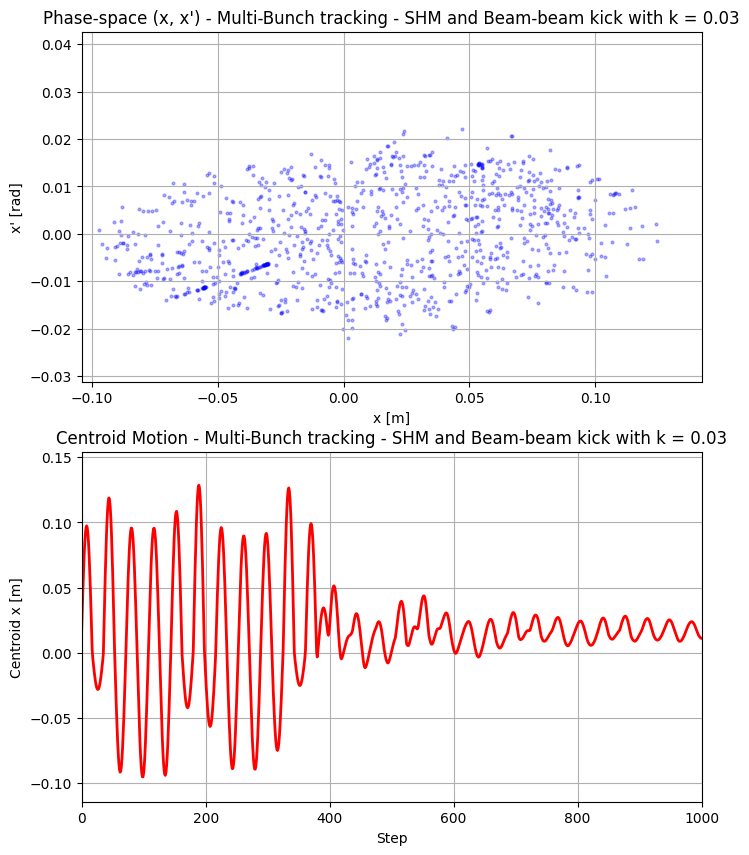

In [16]:
#Animated phase space (x,x') and centroid motion plots:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))

# Phase space subplot:
ax1.set_xlim(np.min(phase_space_steps), np.max(phase_space_steps))  
ax1.set_ylim(10 * k * np.min(phase_space_steps), 10 * k * np.max(phase_space_steps))
ax1.set_xlabel("x [m]")
ax1.set_ylabel("x' [rad]")
ax1.set_title(f"Phase-space (x, x') - Multi-Bunch tracking - SHM and Beam-beam kick with k = {k}")
ax1.grid(True)
scatter = ax1.scatter([], [], s=4, c='blue', alpha=0.3)

# Centroid subplot
ax2.set_xlim(0, len(centroid))
ax2.set_ylim(min(centroid) * 6/5, max(centroid) * 6/5)
ax2.set_xlabel("Step")
ax2.set_ylabel("Centroid x [m]")
ax2.set_title(f"Centroid Motion - Multi-Bunch tracking - SHM and Beam-beam kick with k = {k}")
ax2.grid(True)
line, = ax2.plot([], [], lw=2, c='red')

# Animation function:
def animate(i):
    # Phase-space DATA:
    data = np.vstack(phase_space_steps[i]).T
    scatter.set_offsets(data)
    
    # Centroid DATA:
    line.set_data(range(i+1), centroid[:i+1])
    
    return scatter, line


# Run animation
from IPython.display import HTML

anim = animation.FuncAnimation(fig, animate, frames=len(centroid), interval=10, blit=True)
HTML(anim.to_html5_video())

anim.save(filename = "SHM_and_Beam_Beam_Kick.gif", writer = 'Pillow')

In [15]:
emittance_x = []
for step_data in phase_space_steps:
    x   = step_data[0]    # x positions at this step
    xp  = step_data[1]    # x' momenta at this step
    # RMS emittance formula: ε_x = sqrt(<x^2><xp^2> - <x*xp>^2)
    eps = np.sqrt(np.mean(x ** 2) * np.mean(xp ** 2) - np.mean(x * xp) ** 2)
    emittance_x.append(eps)

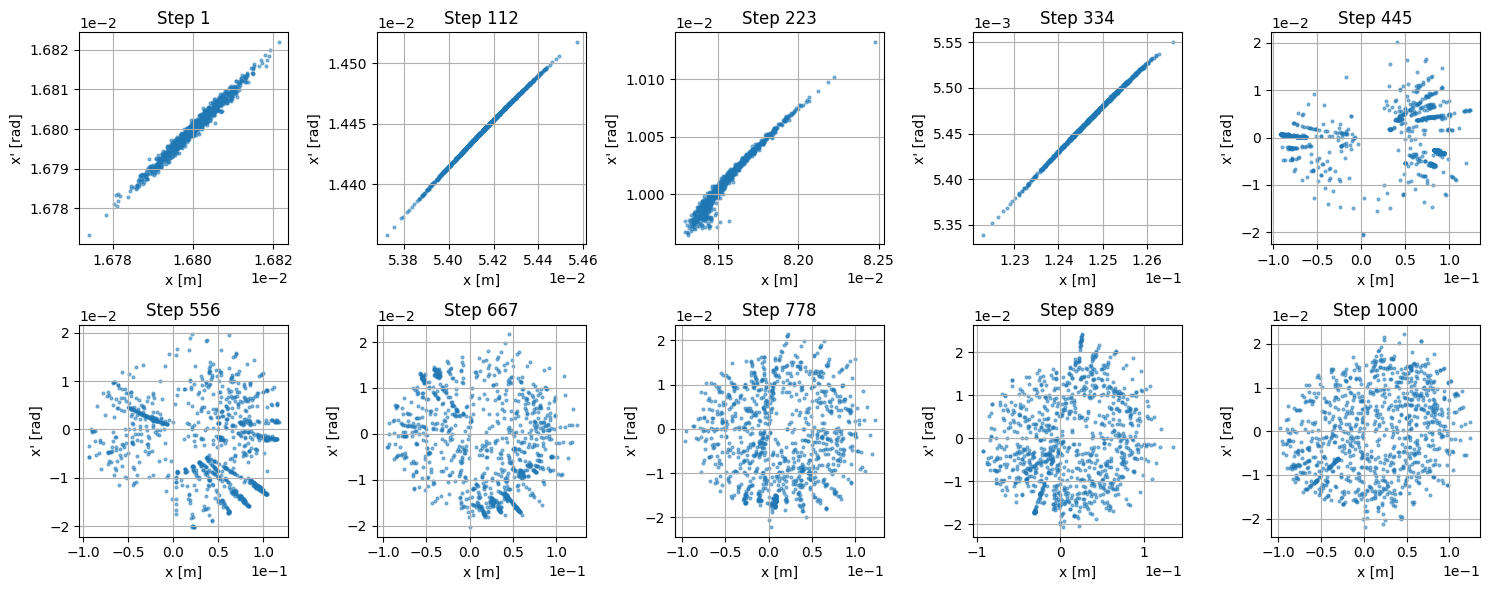

In [14]:
# Here we plot the phase space deformation with space charge in snapshots. 
# If you choose space_charge = False, then the phase space without space charge is depicted:
i = np.array(np.linspace(1, turns, int(turns / ((turns-50) / 10) ))).astype(int) # The number of plots will be shown (custom steps)
figure, axis = plt.subplots(2, 5, figsize=(15, 6))
axis         = axis.flatten()

for s, n in enumerate(i): # s: subplots, n: number of plots
    x, xp = phase_space_steps[n-1]
    axis[s].scatter(x, xp, s = 4, alpha = 0.5)
    axis[s].set_title(f"Step {n}")
    axis[s].set_xlabel("x [m]")
    axis[s].set_ylabel("x' [rad]")
    axis[s].grid(True)

    axis[s].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axis[s].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

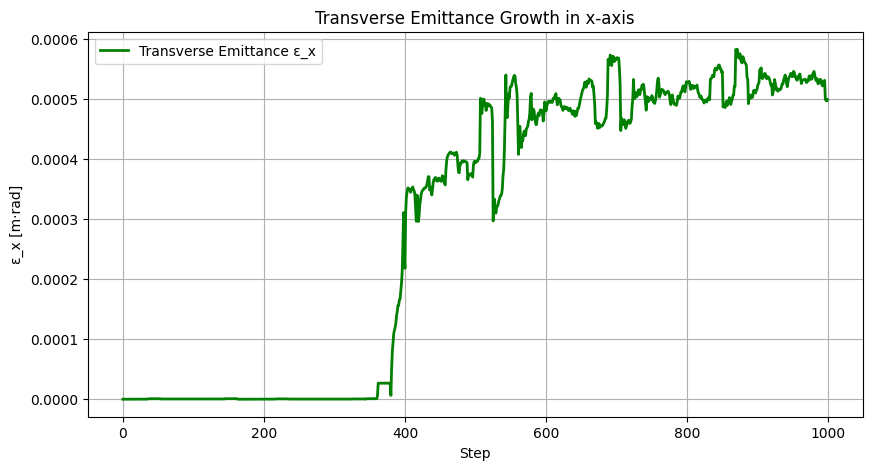

In [13]:
plt.figure(figsize=(10,5))
plt.plot(emittance_x, color='green', lw=2, label='Transverse Emittance ε_x')
plt.xlabel("Step")
plt.ylabel("ε_x [m·rad]")
plt.title("Transverse Emittance Growth in x-axis")
plt.grid(True)
plt.legend()
plt.show()

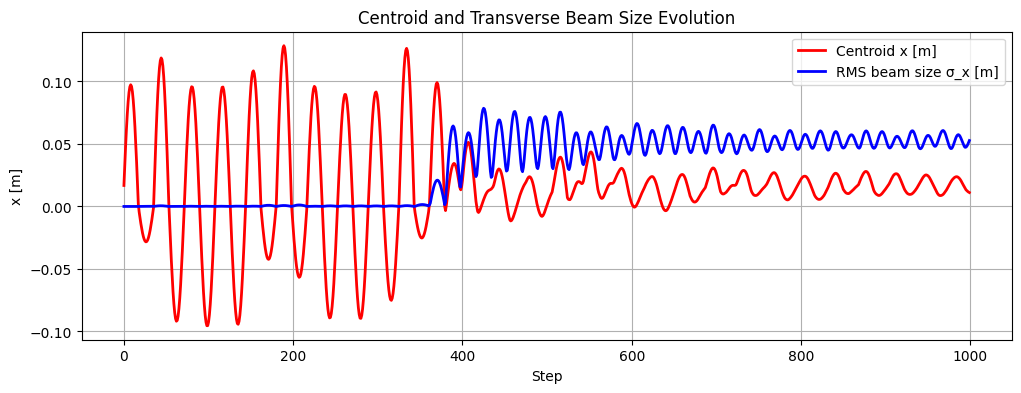

In [12]:
rms_x = [np.std(step[0]) for step in phase_space_steps]

plt.figure(figsize=(12,4))
plt.plot(centroid, label='Centroid x [m]', color='red', lw=2)
plt.plot(rms_x, label='RMS beam size σ_x [m]', color='blue', lw=2)
plt.xlabel("Step")
plt.ylabel("x [m]")
plt.title("Centroid and Transverse Beam Size Evolution")
plt.grid(True)
plt.legend()
plt.show()